<a href="https://colab.research.google.com/github/Teitei011/Artificial-Intelligence/blob/master/training_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Teitei011/X_Ray_Corona

Cloning into 'X_Ray_Corona'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 55 (delta 0), reused 55 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [0]:
cd X_Ray_Corona/dataset

/content/X_Ray_Corona/dataset/X_Ray_Corona/dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import time 
import cv2
import os

import warnings
warnings.filterwarnings("ignore")

<center> <h2> </h2></center>

In [0]:
path = "/content/drive/My Drive/CoronaVirus/"
file_path = path + "/DataSet"
args = [file_path, "plot.png"]


# Initialize the initial learning rate, number of epochs to train for,  batch size
INIT_LR = 1e-3
EPOCHS = 50
BS = 8

## Loading Images 

In [15]:
data = []
labels = []

print("[INFO] Loading images")
data = np.load("/content/drive/My Drive/CoronaVirus/Processed_images/data.npy")
labels = np.load("/content/drive/My Drive/CoronaVirus/Processed_images/labels.npy")
print("[INFO] All images has been loaded")

[INFO] Loading images
[INFO] All images has been loaded


In [5]:
print("[INFO] Pixels matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] Pixels matrix: 1754.59MB


##  One-hot encoding of the labels and creating the training/testing splits 

In [16]:
print("[INFO] Performing one-hot enconding on the labels")
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


print("[INFO] Partitioning the data into training and testing")
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

print("[INFO] Initializing the training data augmentation object")
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")


[INFO] Performing one-hot enconding on the labels
[INFO] Partitioning the data into training and testing
[INFO] Initializing the training data augmentation object


## The Model

In [17]:
# From here we will initialize our VGGNet model and set it up for fine-tuning:

print("[INFO] Initializing the VGGNet model ")
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel) #64
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
  
print("[INFO] VGGNet model initiated")

[INFO] Initializing the VGGNet model 
[INFO] VGGNet model initiated


##Compiling and training the model 


In [24]:
# We’re now ready to compile and train our COVID-19 (coronavirus) deep learning model:
start = time.time()
# compile our model
print("[INFO] Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] Training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] It took {:.2f} seconds".format(time.time() - start))

[INFO] Compiling model...
[INFO] Training head...
Epoch 1/50
74/74 [==============================] - 8s 110ms/step - loss: 0.4248 - accuracy: 0.7990 - val_loss: 0.4739 - val_accuracy: 0.8000
Epoch 2/50
74/74 [==============================] - 8s 107ms/step - loss: 0.4022 - accuracy: 0.8153 - val_loss: 0.4811 - val_accuracy: 0.7733
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.3981 - accuracy: 0.8203 - val_loss: 0.5172 - val_accuracy: 0.7667
Epoch 4/50
74/74 [==============================] - 8s 105ms/step - loss: 0.4138 - accuracy: 0.8271 - val_loss: 0.4965 - val_accuracy: 0.7533
Epoch 5/50
74/74 [==============================] - 8s 106ms/step - loss: 0.4058 - accuracy: 0.8034 - val_loss: 0.4718 - val_accuracy: 0.7800
Epoch 6/50
74/74 [==============================] - 8s 106ms/step - loss: 0.3899 - accuracy: 0.8119 - val_loss: 0.5910 - val_accuracy: 0.6933
Epoch 7/50
74/74 [==============================] - 8s 106ms/step - loss: 0.4007 - accuracy: 0.818

## Evaluating the model 

In [19]:
# make predictions on the testing set
print("[INFO] Evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,	target_names=lb.classes_))

[INFO] Evaluating network...
              precision    recall  f1-score   support

    CT_COVID       0.70      0.89      0.78        70
 CT_NonCOVID       0.87      0.66      0.75        80

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.79      0.77      0.76       150



In [21]:
# Next we’ll compute a confusion matrix for further statistical evaluation:

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# print(cm)
print("Accuracy: {:.4f}%".format(acc*100))
print("Sensitivity: {:.4f}%".format(sensitivity*100))
print("Specificity: {:.4f}%".format(specificity*100))


Accuracy: 76.6667%
Sensitivity: 88.5714%
Specificity: 66.2500%


## Ploting the training accuracy/loss 


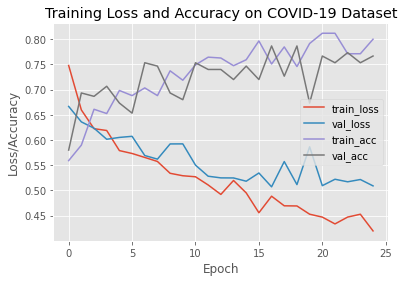

In [22]:
# We then plot our training accuracy/loss history for inspection, outputting the plot to an image file:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig(path + "plot.png")

##Saving the model 

In [0]:
# Finally we serialize our tf.keras COVID-19 classifier model to disk:

# serialize the model to disk
PATH = "/content/drive/My Drive/CoronaVirus/Models/"
model_name = PATH + "covid19_" + str(np.ceil(time.time())) + ".model" 

print("[INFO] Saving COVID-19 detector model...")
model.save(model_name, save_format="h5")
print("[INFO] COVID-19 saved at {}".format(model_name))

[INFO] Saving COVID-19 detector model...
[INFO] COVID-19 saved at /content/drive/My Drive/CoronaVirus/Models/covid19_1588968328.0.model
